# **Ex4**

## Names and IDs

1.   208391037 - Nadav Arbel
2.   207060914 - Yuval Gorelik


## Import All Packages
Add all imports needed for this notebook to run

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import sensitivity_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import time

## Loading the Data
Import the data and preprocces


In [55]:
data = pd.read_csv('ex4_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8746 entries, 0 to 8745
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   INTENSIVE           8746 non-null   object 
 1   NEWSITEID           8281 non-null   float64
 2   RISK10YRS           8746 non-null   float64
 3   INCLUSIONFRS        8746 non-null   bool   
 4   SBP                 8746 non-null   int64  
 5   DBP                 8746 non-null   int64  
 6   N_AGENTS            8746 non-null   int64  
 7   NOAGENTS            8746 non-null   bool   
 8   SMOKE_3CAT          8746 non-null   int64  
 9   ASPIRIN             8746 non-null   bool   
 10  EGFR                8746 non-null   float64
 11  SCREAT              8746 non-null   float64
 12  SUB_CKD             8746 non-null   bool   
 13  RACE_BLACK          8746 non-null   bool   
 14  AGE                 8746 non-null   int64  
 15  FEMALE              8746 non-null   bool   
 16  SUB_CV

At first, let's change all columns to be numeric

In [56]:
not_numbers = []
columns = list(data.columns)
types = list(data.dtypes)
for i in range(len(types)):
  if str(types[i]) != 'float64':
    if str(types[i]) != 'int64':
      not_numbers.append(columns[i])
not_numbers.remove('EVENT_PRIMARY')
for col in not_numbers:
  col_ohe = pd.get_dummies(data[col], prefix=col)
  data = pd.concat((data, col_ohe), axis=1).drop(col, axis=1)

Now, let's check if we have null values in our dataset

In [57]:
data.isnull().sum()

NEWSITEID                   465
RISK10YRS                     0
SBP                           0
DBP                           0
N_AGENTS                      0
SMOKE_3CAT                    0
EGFR                          0
SCREAT                        0
AGE                           0
CHR                           0
GLUR                          0
HDL                           0
TRR                           0
UMALCR                        0
BMI                           0
SBPTERTILE                    0
EVENT_PRIMARY                 0
INTENSIVE_Intensive           0
INTENSIVE_Regular             0
INCLUSIONFRS_False            0
INCLUSIONFRS_True             0
NOAGENTS_False                0
NOAGENTS_True                 0
ASPIRIN_False                 0
ASPIRIN_True                  0
SUB_CKD_False                 0
SUB_CKD_True                  0
RACE_BLACK_False              0
RACE_BLACK_True               0
FEMALE_False                  0
FEMALE_True                   0
SUB_CVD_

We notice that only the 'NEWSITEID' column has null values, so we need to handle it. 
Because the rows with null value are around 5% of our samples, we can't just throw them away. The column 'NEWSITEID' contains site ID in which the participant was treated, and because id is not a numeric value, we can't just assign mean/avg instead of the missing values. We also though to assign the most common value, but we think we can do better. We decided to try to predict the 'NEWSITEID' with the other columns and features we have. Let's check the correlation between the colums and see if any other column has high correlation with 'NEWSITEID'.

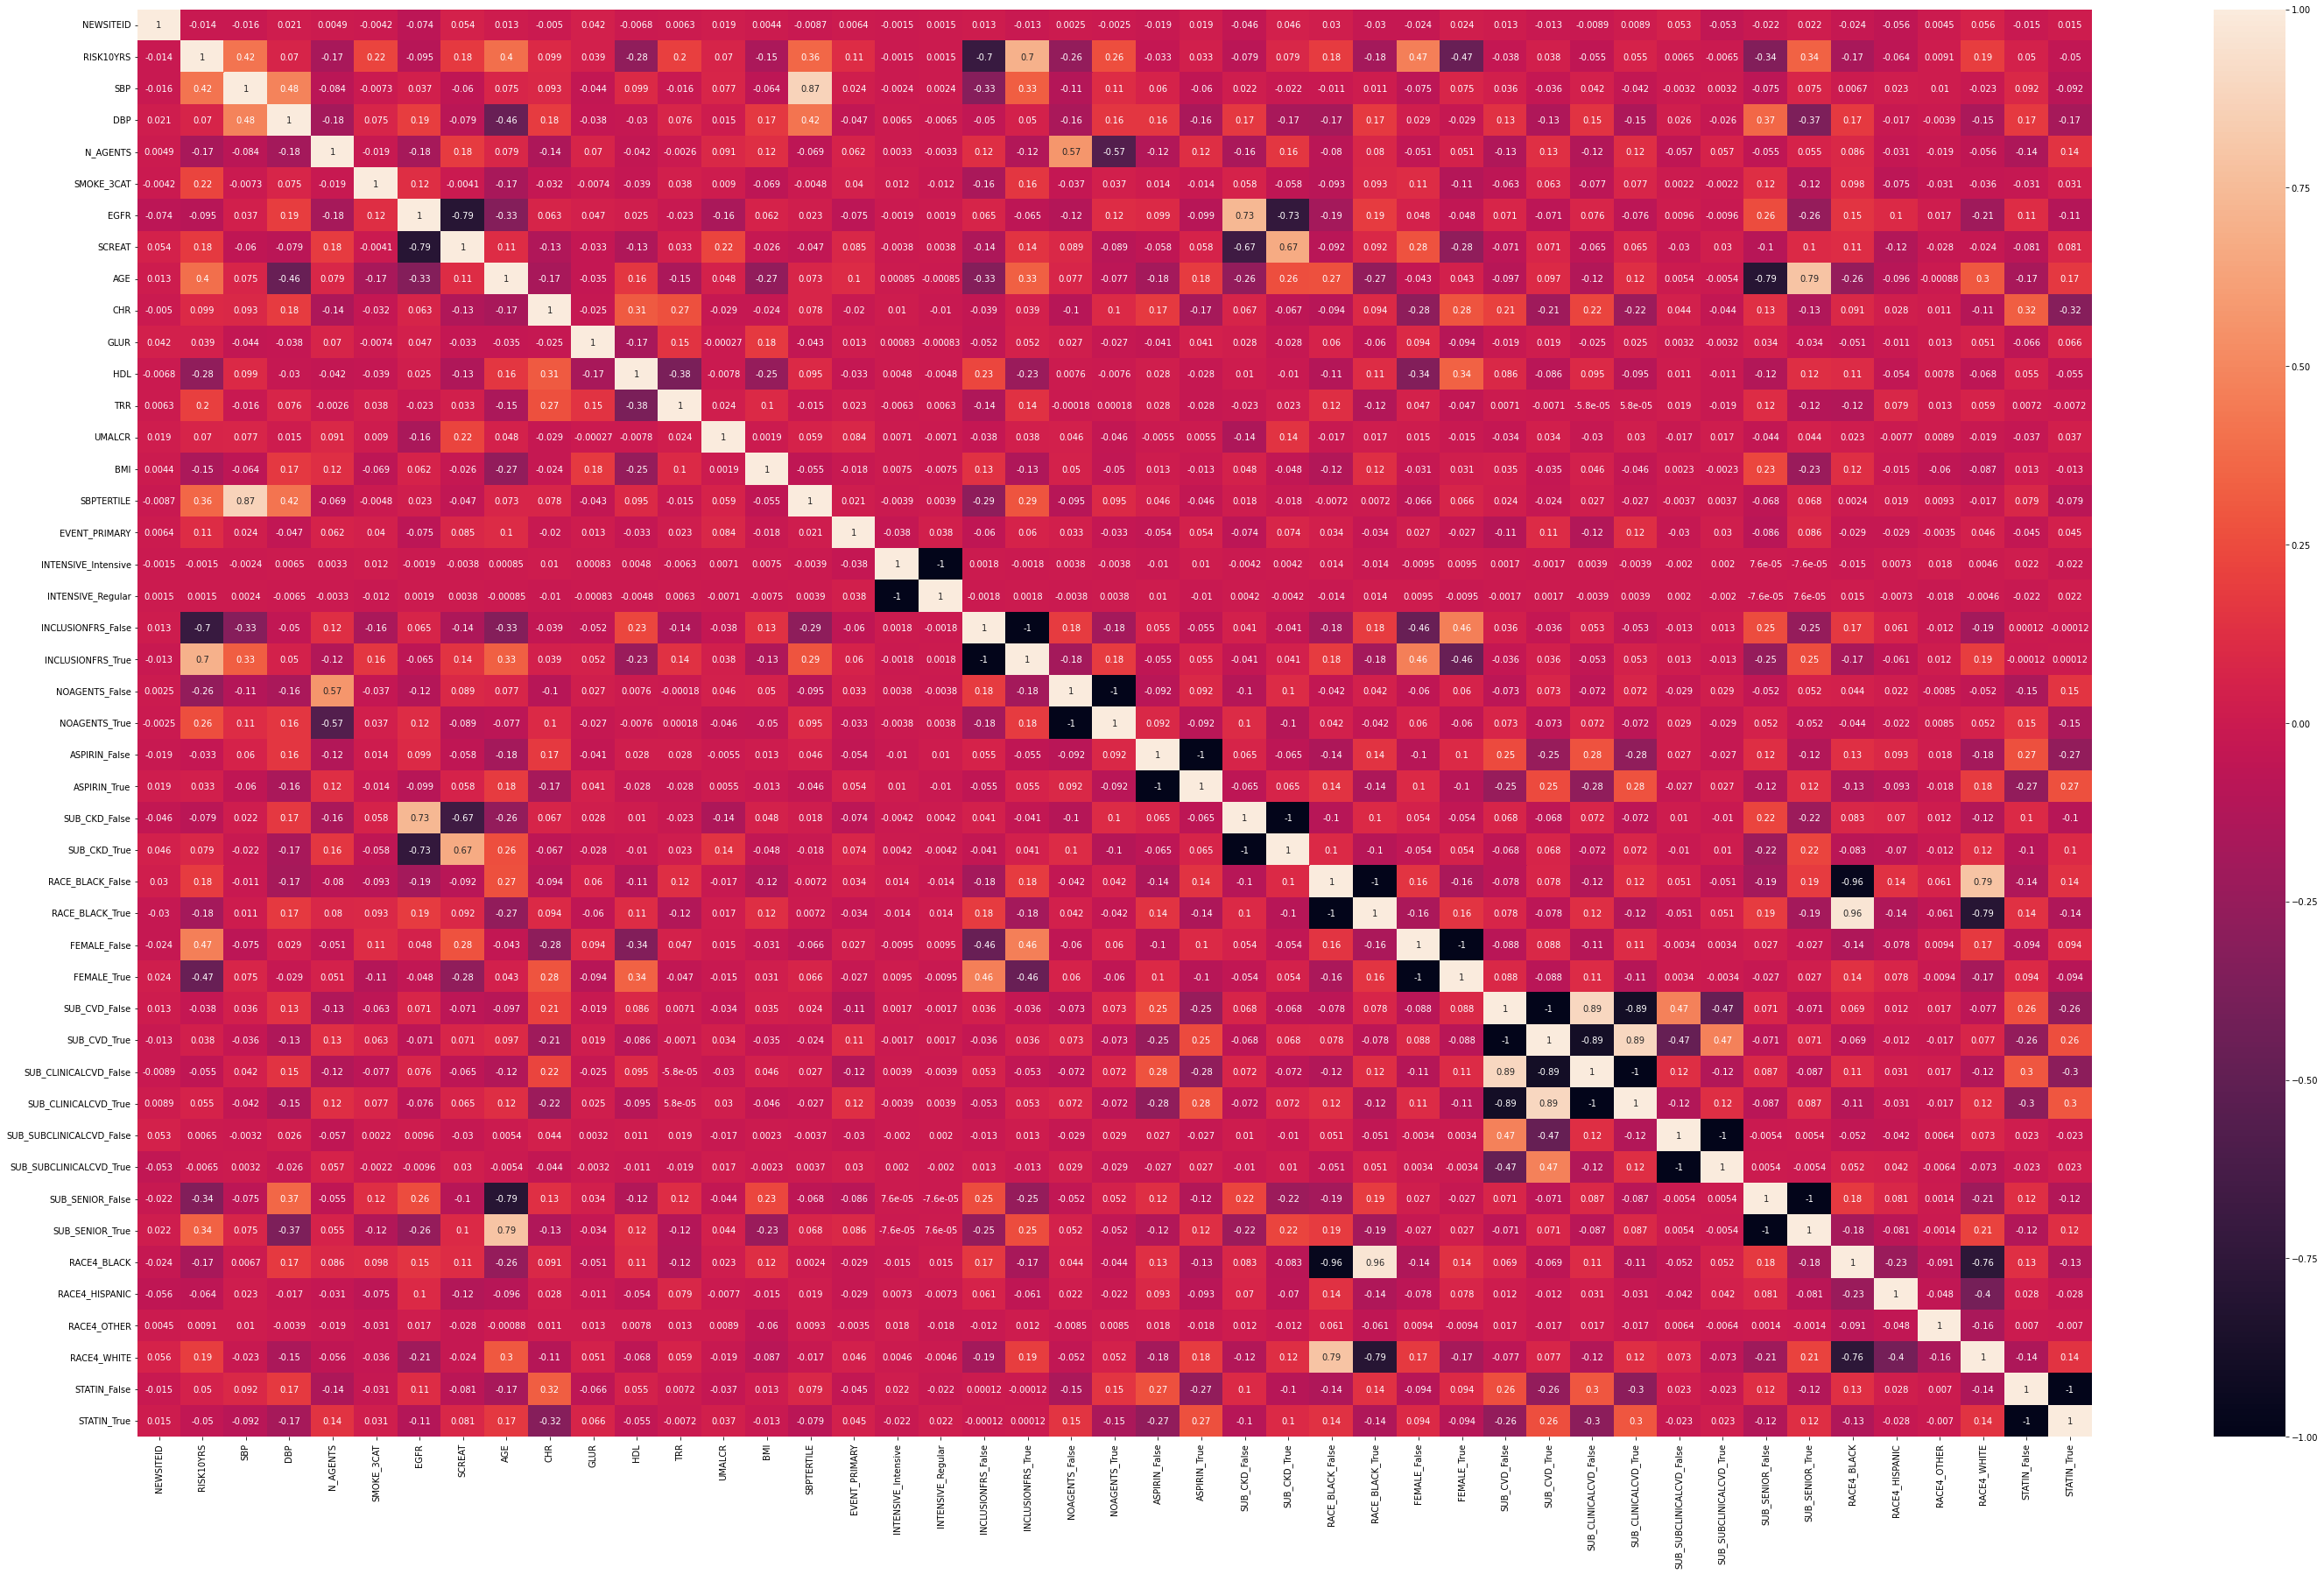

In [58]:
plt.figure(figsize=(50, 30))
sns.heatmap(data.corr(), annot=True)
plt.show()

Unfortunately, there isn't such column so we will use all features the predict 'NEWSITEID'

In [59]:
data_filter = data[data['NEWSITEID'] > 0].copy()

y_pred = []
y_true = []

kf = KFold(n_splits=10)
for train_index, test_index in kf.split(data_filter):
    df_test = data_filter.iloc[test_index]
    df_train = data_filter.iloc[train_index]

    df_train = df_train.drop('EVENT_PRIMARY', 1)
    df_test = df_test.drop('EVENT_PRIMARY', 1)
    
    X_train = np.array(df_train.drop('NEWSITEID', 1))  
    y_train = np.array(df_train['NEWSITEID']).reshape(-1, 1)
    X_test = np.array(df_test.drop('NEWSITEID', 1)) 
    y_test = np.array(df_test['NEWSITEID']).reshape(-1, 1)

    model = SVC()
    model.fit(X_train, y_train.flatten())

    y_pred.append(model.predict(X_test))
    y_true.append(y_test.flatten())



In [60]:
for i in range(len(y_true)):
  print(accuracy_score(y_true[i], y_pred[i]))

0.05910735826296743
0.04589371980676329
0.05434782608695652
0.043478260869565216
0.04710144927536232
0.03864734299516908
0.04106280193236715
0.043478260869565216
0.05314009661835749
0.05434782608695652


In all folds, the results we got are very poor (there are around 100 categories so it make sense it didn't work) so we will just put a default value (new site id) instead of the nulls because we don't want to drop the whole column/the rows which contain the null values.

In [61]:
data = data.fillna(0)

In [62]:
col_ohe = pd.get_dummies(data['NEWSITEID'], prefix='NEWSITEID')
data = pd.concat((data, col_ohe), axis=1).drop('NEWSITEID', axis=1)

Thats it, we finished the preproccesing part, now it's time to start the training section

##Training the models

splitting the data into train and test and scalling

In [63]:
X = data.drop('EVENT_PRIMARY', 1)
y = data['EVENT_PRIMARY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)
standScaler = StandardScaler(with_mean=False)
X_train = standScaler.fit_transform(X_train)
X_test = standScaler.fit_transform(X_test)

When we started this exercise we used the data as it is and tried to find the best accuracy. The result were phenomenal, 93% accuracy, but then we understood what was wrong: the samples are imbalanced and 93% accuracy occourd because the classifiers classified all data as false, and were correct on 93%. The data set is from a clinical trial, so the main goal for us is to maximize the sensetivity. In order to find the best model we used 'GridSearchCV' for each algorithm which finds the best paramaters using cross validation, and we defined "best" as **highest sensitivity score** (imported from imblearn package). Additionaly, we wanted to balance the data set so we used 'SMOTE' function (also from imblearn package) to generate True samples.

In [64]:
sm = SMOTE(random_state=25)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [65]:
print('Resampled dataset shape %s' % Counter(y_train))

Resampled dataset shape Counter({False: 6551, True: 6551})


In linear classifiers and ensemble models, we will examine 3 models of each one of them and pick the best. After that, we will choose the best overall model.
Since this dataset deals with clinical data, we understand that there always be some kind of tradeoff between the sensitivity and accuracy so there is no such thing as the "best" model, but we can try to choose the most appropriate to our needs based on the losses we can take.

###linear classifier

####Logistic Regression

In [66]:
#grid-search
clf = LogisticRegression()
parameters = {'penalty': ['l2'],
              'C': [0.5, 1, 1.5],
              'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
             }

warnings.filterwarnings('ignore')

grid_obj = GridSearchCV(clf, parameters,
                        scoring=sensitivity_score,
                        return_train_score=True)
grid_obj = grid_obj.fit(X_train, y_train)

In [67]:
print(grid_obj.best_params_)

{'C': 0.5, 'penalty': 'l2', 'solver': 'newton-cg'}


In [68]:
clf = grid_obj.best_estimator_
clf.fit(X_train, y_train)
print("Accuracy score on train set:" + str(accuracy_score(y_train, clf.predict(X_train))))
print("Accuracy score on test set:" + str(accuracy_score(y_test, clf.predict(X_test))))

Accuracy score on train set:0.7093573500228972
Accuracy score on test set:0.6868571428571428


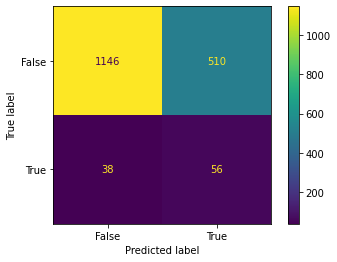

In [69]:
plot_confusion_matrix(clf,X_test,y_test)

In [70]:
#creating ROC curve
y_score = clf.fit(X_train, y_train).decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
  fpr[i], tpr[i], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plot1 = (
    fpr[1],
    tpr[1],
    "pink",
    "Logistic Regression - ROC curve (area = %0.2f)" % roc_auc[1],
)

####SGD Classifier

In [71]:
#grid-search
clf = SGDClassifier()
parameters = {'penalty': ['l1', 'l2', 'elasticnet'],
              'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
              'loss': ['hinge', 'modified_huber', 'log', 'squared_error'],
              'class_weight':['balanced'],
              'eta0' : [0.00001]
             }

warnings.filterwarnings('ignore')

grid_obj = GridSearchCV(clf, parameters,
                        scoring=sensitivity_score,
                        return_train_score=True)
grid_obj = grid_obj.fit(X_train, y_train)

In [72]:
print(grid_obj.best_params_)

{'class_weight': 'balanced', 'eta0': 1e-05, 'learning_rate': 'constant', 'loss': 'hinge', 'penalty': 'l1'}


In [73]:
clf = grid_obj.best_estimator_
clf.fit(X_train, y_train)
print("Accuracy score on train set:" + str(accuracy_score(y_train, clf.predict(X_train))))
print("Accuracy score on test set:" + str(accuracy_score(y_test, clf.predict(X_test))))

Accuracy score on train set:0.6963822317203481
Accuracy score on test set:0.6834285714285714


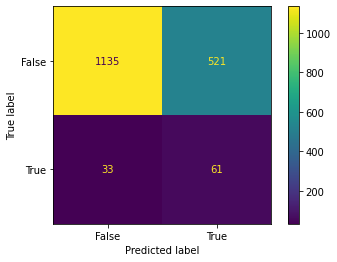

In [74]:
plot_confusion_matrix(clf,X_test,y_test)

In [75]:
#creating ROC curve
y_score = clf.fit(X_train, y_train).decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
  fpr[i], tpr[i], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plot2 = (
    fpr[1],
    tpr[1],
    "darkorange",
    "SGD - ROC curve (area = %0.2f)" % roc_auc[1],
)

####Ridge Classifier

In [76]:
#grid-search
clf = RidgeClassifier()
parameters = {'alpha': [0.5, 1, 1.5],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
             }
warnings.filterwarnings('ignore')

grid_obj = GridSearchCV(clf, parameters,
                        scoring=sensitivity_score,
                        return_train_score=True)
grid_obj = grid_obj.fit(X_train, y_train)

In [77]:
print(grid_obj.best_params_)

{'alpha': 0.5, 'solver': 'auto'}


In [78]:
clf = grid_obj.best_estimator_
clf.fit(X_train, y_train)
print("Accuracy score on train set:" + str(accuracy_score(y_train, clf.predict(X_train))))
print("Accuracy score on test set:" + str(accuracy_score(y_test, clf.predict(X_test))))

Accuracy score on train set:0.7066860021370783
Accuracy score on test set:0.6788571428571428


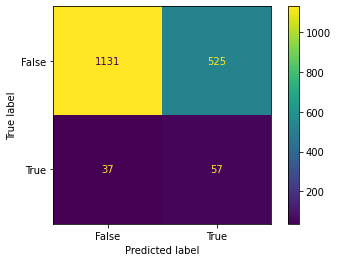

In [79]:
plot_confusion_matrix(clf,X_test,y_test)

In [80]:
#creating ROC curve
y_score = clf.fit(X_train, y_train).decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
  fpr[i], tpr[i], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plot3 = (
    fpr[1],
    tpr[1],
    "navy",
    "Ridge Classifier - ROC curve (area = %0.2f)" % roc_auc[1],
)

####ROC Curves

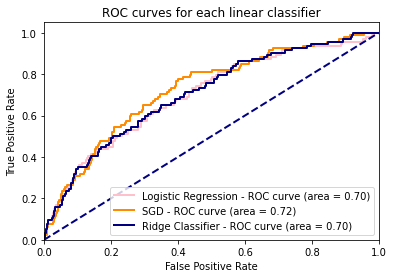

In [81]:
plt.figure()
lw = 2
for roc in [plot1, plot2, plot3]:
  plt.plot(
      roc[0],
      roc[1],
      color=roc[2],
      lw=lw,
      label=roc[3],
  )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for each linear classifier")
plt.legend(loc="lower right")
plt.show()

We chose 3 differnt linear classifier and tried to find the best one of them. All 3 gave us good results both on traing and test data, so we plotted the ROC curves of each of them. Since all 3 models have similar sensetivity scores we will choose our model based on the accuracy score and the AUC: in "photo finish", the **SGD** Classifier has the best accuracy and ROC values and we will choose it for the final comparison.

###Ensemble models

####AdaBoost Classifier

In [82]:
#grid-search
clf = AdaBoostClassifier()
parameters = {'n_estimators': [200, 250],
              'learning_rate': [0.001, 0.01, 0.1],
              'algorithm': ['SAMME', 'SAMME.R'],
              'base_estimator':[DecisionTreeClassifier(max_depth=1, max_features='auto')],
             }

warnings.filterwarnings('ignore')

grid_obj = GridSearchCV(clf, parameters,
                        scoring=sensitivity_score,
                        return_train_score=True)
grid_obj = grid_obj.fit(X_train, y_train)

In [83]:
print(grid_obj.best_params_)

{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(max_depth=1, max_features='auto'), 'learning_rate': 0.001, 'n_estimators': 200}


In [84]:
clf = grid_obj.best_estimator_
clf.fit(X_train, y_train)
print("Accuracy score on train set:" + str(sensitivity_score(y_train, clf.predict(X_train))))
print("Accuracy score on test set:" + str(sensitivity_score(y_test, clf.predict(X_test))))

Accuracy score on train set:0.8331552434742787
Accuracy score on test set:0.7127659574468085


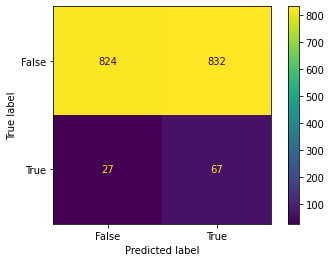

In [85]:
plot_confusion_matrix(clf,X_test,y_test)

In [86]:
#creating ROC curve
y_score = clf.fit(X_train, y_train).decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
  fpr[i], tpr[i], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plot1 = (
    fpr[1],
    tpr[1],
    "pink",
    "AdaBoost Classifier - ROC curve (area = %0.2f)" % roc_auc[1],
)

####RandomForest Classifier

In [87]:
#grid-search
clf = RandomForestClassifier()
parameters = {'n_estimators': [50, 100, 150],
              'criterion': ['gini', 'entropy'],
              'bootstrap': [True, False],
             }
warnings.filterwarnings('ignore')

grid_obj = GridSearchCV(clf, parameters,
                        scoring=sensitivity_score,
                        return_train_score=True)
grid_obj = grid_obj.fit(X_train, y_train)

In [88]:
print(grid_obj.best_params_)

{'bootstrap': True, 'criterion': 'gini', 'n_estimators': 50}


In [89]:
clf = grid_obj.best_estimator_
clf.fit(X_train, y_train)
print("Accuracy score on train set:" + str(accuracy_score(y_train, clf.predict(X_train))))
print("Accuracy score on test set:" + str(accuracy_score(y_test, clf.predict(X_test))))

Accuracy score on train set:0.9999236757746909
Accuracy score on test set:0.676


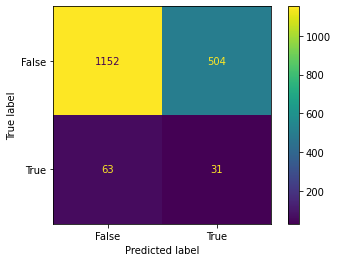

In [90]:
plot_confusion_matrix(clf,X_test,y_test)

In [91]:
#creating ROC curve
y_score = clf.fit(X_train, y_train).predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
  fpr[i], tpr[i], _ = roc_curve(y_test.ravel(), y_score[:,1])
  roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score[:,1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plot2 = (
    fpr[1],
    tpr[1],
    "darkorange",
    "RandomForest Classifier - ROC curve (area = %0.2f)" % roc_auc[1],
)

####Stacking Classifier

In [92]:
#grid-search
parameters = {'estimators': [[('rf', RandomForestClassifier(n_estimators=10)),
                              ('svr', LinearSVC(random_state=42)),
                             ('lr',LogisticRegression()) ,('svm',SVC())]],
              
              'final_estimator': [LogisticRegression(), RidgeCV(), SGDClassifier()],
             }

acc_scorer = make_scorer(accuracy_score)

warnings.filterwarnings('ignore')

grid_obj = GridSearchCV(StackingClassifier(parameters), parameters,
                        scoring=sensitivity_score,
                        return_train_score=True)
grid_obj = grid_obj.fit(X_train, y_train)

In [93]:
print(grid_obj.best_params_)

{'estimators': [('rf', RandomForestClassifier(n_estimators=10)), ('svr', LinearSVC(random_state=42)), ('lr', LogisticRegression()), ('svm', SVC())], 'final_estimator': LogisticRegression()}


In [94]:
clf = grid_obj.best_estimator_
clf.fit(X_train, y_train)
print("Accuracy score on train set:" + str(accuracy_score(y_train, clf.predict(X_train))))
print("Accuracy score on test set:" + str(accuracy_score(y_test, clf.predict(X_test))))

Accuracy score on train set:0.9938177377499618
Accuracy score on test set:0.8257142857142857


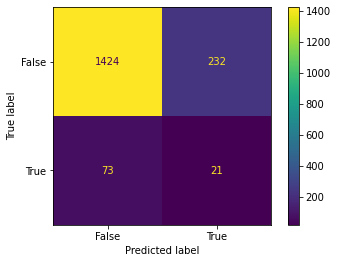

In [95]:
plot_confusion_matrix(clf,X_test,y_test)

In [96]:
#creating ROC curve
y_score = clf.fit(X_train, y_train).decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
  fpr[i], tpr[i], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plot3 = (
    fpr[1],
    tpr[1],
    "navy",
    "Stacking Classifier - ROC curve (area = %0.2f)" % roc_auc[1],
)

####ROC Curves

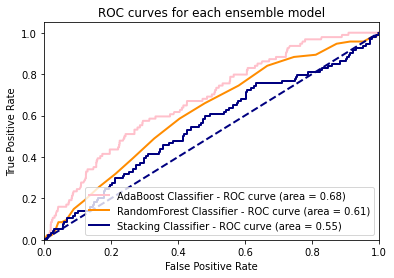

In [97]:
plt.figure()
lw = 2
for roc in [plot1, plot2, plot3]:
  plt.plot(
      roc[0],
      roc[1],
      color=roc[2],
      lw=lw,
      label=roc[3],
  )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for each ensemble model")
plt.legend(loc="lower right")
plt.show()

We chose 3 differnt ensemble classifier and tried to find the best one of them. 
The AdaBoost classifier did not perform well: it classifies many samples as True causing the raise of the sensitivity score, but we can see it overfitted and has low accuracy score. The RandomForest classifier does a much better work compared to AdaBoost. Although the sensetivity score is much lower, the accuracy is significantly higher and the results seems to be more balanced. The Stacking classifier behaved similary to AdaBoost: overfitting the train, but in this case the sensetivity score is much lower than AdaBoost. From the ensemble models section we will choose **RandomForest** for the final comparison.



###Deep Learning

####MLP classifier

In [98]:
#grid-search
clf = MLPClassifier()
parameters = {'hidden_layer_sizes': [(15,)],
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'solver': ['lbfgs', 'adam'],
              'batch_size': [100, 200, 400],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
             }

warnings.filterwarnings('ignore')

grid_obj = GridSearchCV(clf, parameters,
                        scoring=sensitivity_score,
                        return_train_score=True)
grid_obj = grid_obj.fit(X_train, y_train)

In [99]:
print(grid_obj.best_params_)

{'activation': 'identity', 'batch_size': 100, 'hidden_layer_sizes': (15,), 'learning_rate': 'constant', 'solver': 'lbfgs'}


In [100]:
clf = grid_obj.best_estimator_
clf.fit(X_train, y_train)
print("Accuracy score on train set:" + str(accuracy_score(y_train, clf.predict(X_train))))
print("Accuracy score on test set:" + str(accuracy_score(y_test, clf.predict(X_test))))

Accuracy score on train set:0.7094336742482064
Accuracy score on test set:0.724


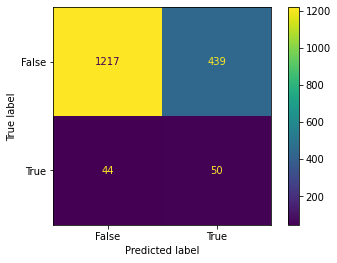

In [101]:
plot_confusion_matrix(clf,X_test,y_test)

####ROC curve

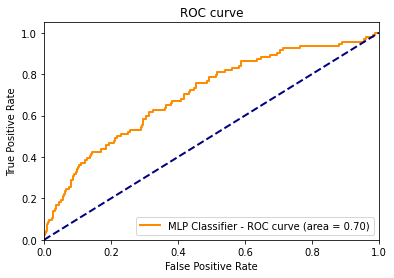

In [102]:
#creating ROC curve
y_score = clf.fit(X_train, y_train).predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
  fpr[i], tpr[i], _ = roc_curve(y_test.ravel(), y_score[:,1])
  roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score[:,1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plot = (
    fpr[1],
    tpr[1],
    "darkorange",
    "MLP Classifier - ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.figure()
lw = 2
for roc in [plot]:
  plt.plot(
      roc[0],
      roc[1],
      color=roc[2],
      lw=lw,
      label=roc[3],
  )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

##Comparison between the models

Linear model acuracy score:0.7091428571428572
execution time: 0.462343692779541

Ensemble model acuracy score:0.4188571428571429
execution time: 2.5382449626922607

DL model acuracy score:0.7302857142857143
execution time: 3.8351497650146484


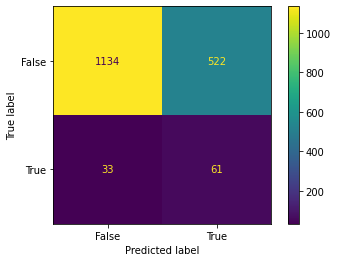

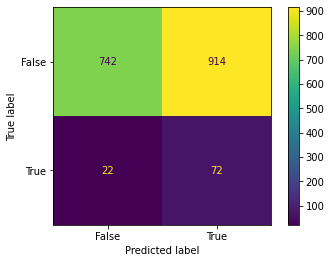

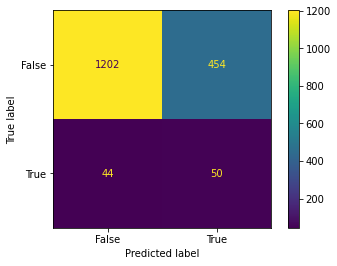

In [103]:
start = time.time()
linear = SGDClassifier(class_weight='balanced', eta0=1e-05, learning_rate='constant', loss='hinge', penalty= 'l1')
linear.fit(X_train, y_train)
print('Linear model acuracy score:' + str(accuracy_score(y_test, linear.predict(X_test))))
print('execution time: ' + str(time.time() - start))
print('')

y_score = linear.fit(X_train, y_train).decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
  fpr[i], tpr[i], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plot1 = (
    fpr[1],
    tpr[1],
    "navy",
    "SGD Classifier - ROC curve (area = %0.2f)" % roc_auc[1],
)
plot_confusion_matrix(linear,X_test,y_test)

start = time.time()
ensemble = AdaBoostClassifier(algorithm= 'SAMME', base_estimator=DecisionTreeClassifier(max_depth=1, max_features='auto'), learning_rate=0.001, n_estimators=200)
ensemble.fit(X_train, y_train)
print('Ensemble model acuracy score:' + str(accuracy_score(y_test, ensemble.predict(X_test))))
print('execution time: ' + str(time.time() - start))
print('')

y_score = ensemble.fit(X_train, y_train).decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
  fpr[i], tpr[i], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plot2 = (
    fpr[1],
    tpr[1],
    "pink",
    "AdaBoost Classifier - ROC curve (area = %0.2f)" % roc_auc[1],
)
plot_confusion_matrix(ensemble,X_test,y_test)

start = time.time()
dl = MLPClassifier(activation='identity', batch_size=100, hidden_layer_sizes=(15,), learning_rate='constant', solver='lbfgs')
dl.fit(X_train, y_train)
print('DL model acuracy score:' + str(accuracy_score(y_test, dl.predict(X_test))))
print('execution time: ' + str(time.time() - start))

y_score = dl.fit(X_train, y_train).predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
  fpr[i], tpr[i], _ = roc_curve(y_test.ravel(), y_score[:,1])
  roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score[:,1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plot3 = (
    fpr[1],
    tpr[1],
    "darkorange",
    "MLP Classifier - ROC curve (area = %0.2f)" % roc_auc[1],
)
plot_confusion_matrix(dl,X_test,y_test)

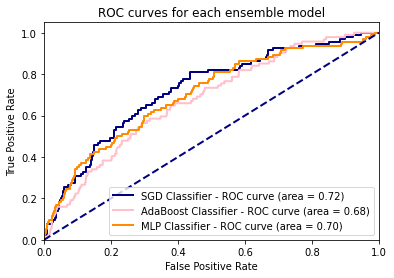

In [104]:
plt.figure()
lw = 2
for roc in [plot1, plot2, plot3]:
  plt.plot(
      roc[0],
      roc[1],
      color=roc[2],
      lw=lw,
      label=roc[3],
  )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for each ensemble model")
plt.legend(loc="lower right")
plt.show()

The linear classifiers doesn't overfit and their accuracy are the lowest, but for our goal which is the highest sensetivity score they do a prety good job.  The ensemble models are a little bit overfitting but their accuracy score for the training set as well as for the test set is very high. Unfortunately, their sensitivity scores are not fit very well with our goal. The MLP classifier doesn't overfit, and has results similar to the linear classifiers. If we had to choose one classifier it probably would be **SGD** Classifier (by number of indices like accuracy, sensetivity, ROC, running time, etc..), but it realy depends on what is our goal: since it's a clinical trial, we believed that sensetivity is the main factor, but in real life there are many other factors which can change our way searching for the best classifier and choosing one.

The batch size defines the number of samples that will be propagated through the network. As the number is lower, the weigths will be updated more frequently and typically the convergence will be faster. Another adventage of using small batch size is the memory isuue: when we have high volume of data we won't be able to keep all of it in memory so small batch bypass it (this is not the case in this work, 9000+= samples are not an example of high volume data). In this exercise we tried a few batch values and in runnig time we saw a big difference: as the number ot the batch was lower, the running time was longer.


*During the work we used also 'make_index_balanced_accuracy' metric which reduced the FN significantly but the accuracy score was much lower. The trade off between accuracy score and sensetivity score depends on many variables, so we had to make an assumption what is the most imporant result we want from our model.